# Regularization
With the development of machine learning algorithms and an increase of th sizes of available datasets the problem of overfitting was growing constantly. The number of parameters in the estimated models is often so large, that overfitting is hindering the predictive power of the model. One possible solution to this problem is regularization.

Regularization is a modification of a loss function in such a way, that it incorporates the information about the value of all parameters. Lets say that we are building an estimator $\hat{F}(X)$ by setting the value of parameters vector $\hat{\beta}$ so that a loss function $L(y-\hat{y})$ is minimized. Regularization changes the loss function so that $L' = L(y-\hat{y}) + R(\hat{\beta})$, where $R(\hat{\beta})$ is an additional cost that increases with the increase of the size of parameters $\hat{\beta}$.

## Why use regularization
The main goal of regularization is to decrease overfitting or in other words to increase its generalization. We achieve this through a decrease in the variance of our estimator, that arises from the large number or size of the parameters. How does regularization achieves this?

Lets put ourself in the position of an optimizing agent that build our estimator $\hat{F}(X)$. When making modifications to the estimator, even the smallest ones, as it does not cost us anything, we will keep changing it as long as we can find anything to improve. In supervised learning this optimizing agent bases its creation of the estimator on the training set. We are making $\hat{F}(X)$ closer to the $F(X)$ by a "coincident", as it is easier to explain the training set by real, general rules, than a description of individual observations. However the smaller the gains from altering our estimator, the greater the chance that we are capturing a charachteristic of the training set (describing individual observatons) and not a general rule.

Lets sat that we should "explain" a person weight based on the observation of people in the room. We would do a fairly decent job just by saying that taller people are heavier. Then  we would probably say that men are on average heavier than women, and so on. At one point we would run out of "sensible" rules. This would make us create rules that apply to small groups of individuals or even single observations. This would lead to overfitting (overweight).

Making adding new rules costly forces our optimizing agent to take the trade off between cost of a new rule and the gains in the reduction of loss function it leads to into consideration. Depending on the way in which this cost is introduced to the loss function it can lead to a decrease of a parameter or even its elimination.

## Regularization L1 i L2
Let's assume that our loss function is given by:
$$L' = L(y-\hat{y}) + R(\hat{\beta})$$
where $L(y-\hat{y})$ is a loss function without regularization and $R(\hat{\beta})$ is a regularization term.

There are three main types of regularization: $L_1$ (Lasso), $L_2$ (Ridge) or a combination of $L_1$ i $L_2$ so called *Elastic Net*.
* Lasso:
$$R_{L_1} = \alpha \sum_{i=0}^{k} |\beta_i|$$
* Ridge
$$R_{L_2} = \alpha \sum_{i=0}^{k} |\beta_i|^2$$
* Elastic Net 
$$R_{EN} = \alpha \sum_{i=0}^{k} [\gamma|\beta_i| + (1-\gamma)|\beta_i|^2]$$

* With introduction of regularization it may not be possible to find a solution analyticaly. Therefore numerical methods must be used.
* If only $L_1$ regularization is used there can exist multiple optimal solutions.


### Lasso, Ridge i Elastic Net
The different form of regularization term leads to different effects.
* In Lasso ($L_1$) as there are no diminishing returns to the decrease of a parameter some parameters can be reduced to zero. As a result Lasso is also a form of variable selection (filtering).
* In Ridge ($L_2$) there are diminishing returns to the decrease of a parameter as a quadratic function is very flat near zero. Therefore parameters are almost never decreased to zero.
* When we use Elastic Net in linear models it tends to "group" corellated variables. Their parameters are kept at similar level.

Let's take a look at the effect of different levels of regularization on the value of parameters. With this synthetic example below we can clearly see how different is Ridge regularization to Lasso regularization.

In [1]:
# Author: Fabian Pedregosa -- <fabian.pedregosa@inria.fr>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import warnings

# X is the 10x10 Hilbert matrix
X = 1. / (np.arange(1, 11) + np.arange(0, 10)[:, np.newaxis])
y = np.ones(10)

# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-7, -2, n_alphas)

coefsR = []
coefsL = []

for a in alphas:
    
    with warnings.catch_warnings(): # I am hiding warning here.
        
        warnings.filterwarnings("ignore")
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefsR.append(ridge.coef_)

        lasso = linear_model.Lasso(alpha=a, fit_intercept=False)
        lasso.fit(X, y)
        coefsL.append(lasso.coef_)

# #############################################################################
# Display results

fig, az = plt.subplots(1, 2, figsize=(12,4))
az = az.flatten()


az[0].plot(alphas, coefsR)
az[0].set_xscale('log')
# az[0].set_xlim(az[0].get_xlim()[::-1])  # reverse axis
az[0].set_xlabel('alpha')
az[0].set_ylabel('weights')
az[0].set_title('Ridge coefficients as a function of the regularization')

az[1].plot(alphas, coefsL)
az[1].set_xscale('log')
# az[1].set_xlim(az[1].get_xlim()[::-1])  # reverse axis
az[1].set_xlabel('alpha')
az[1].set_ylabel('weights')
az[1].set_title('LASSO coefficients as a function of the regularization')

plt.tight_layout()

plt.show()

In the example above we can clearly see that Ridge regression is more stable and changes in parameteres with the size of alpha are more gradual. Especially for larger values of alpha we see that for Ridge all parameters approach zero simultaneously, where for Lasso they drop to zero in certain order. What's more, some parameters can go down to zero with increase of alpha and get positive again with its further increase.

## Regularization with large number of variables
Lets use Milan weather data to look at this problem. We will use hourly temperature data.

In [9]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.style.use('seaborn-ticks')
%matplotlib inline

plTemp = pd.read_pickle(".../data/weather_data.p")


<AxesSubplot:xlabel='hour', ylabel='temp'>

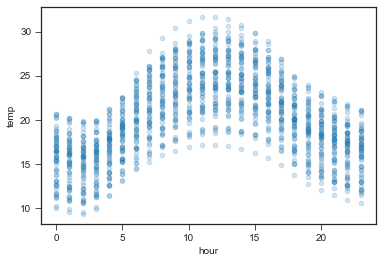

In [10]:
# You can play a bit with the conditions, to make more or less data go into the model and see the effect.

plTemp = plTemp[plTemp.month == 7]
plTemp = plTemp[plTemp.year >= 2018]

plTemp.plot.scatter("hour", "temp", alpha=0.2)


### Benchmark
Let's see how linear model will work without regularization when we start adding additional polynominal elements as features.

In [11]:
from sklearn import linear_model

In [12]:
features = ["hour"]
preds = []
coefs = []
hours = pd.DataFrame(list(range(24)), columns=["hour"])

for power in range (2, 11):
    
    plTemp["hour"+str(power)] = plTemp.hour**power 
    hours["hour"+str(power)] = hours.hour**power 
    features.append("hour"+str(power))
    regr = linear_model.LinearRegression()
    regr.fit(plTemp[features], plTemp["temp"])
    pred = regr.predict(hours[features])
    preds.append(pred)
    coefs.append(dict(zip(hours.columns, regr.coef_)))
    
coefs = pd.DataFrame(coefs)[hours.columns.tolist()]
coefs

hour     hour2     hour3     hour4     hour5         hour6  \
0  1.821602 -0.074865       NaN       NaN       NaN           NaN   
1  1.439996 -0.032491 -0.001228       NaN       NaN           NaN   
2 -1.023762  0.473688 -0.035929  0.000754       NaN           NaN   
3 -1.402442  0.598717 -0.050852  0.001491 -0.000013           NaN   
4 -1.539018  0.665478 -0.063002  0.002501 -0.000052  5.638650e-07   
5 -1.839844  0.871252 -0.115829  0.009001 -0.000464  1.358403e-05   
6 -0.194577 -0.635100  0.401224 -0.078412  0.007592 -3.989925e-04   
7  0.401007 -1.336664  0.710111 -0.146599  0.016081 -1.021798e-03   
8 -0.172437 -0.499989  0.253799 -0.020054 -0.004179  9.616380e-04   

          hour7         hour8         hour9        hour10  
0           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN  
5 -1.617412e-07           NaN           NaN           NaN  
6  1.086245e-05 -1.198282e-07           NaN           NaN  
7  3.756244e-05 -7.381959e-07  5.974567e-09           NaN  
8 -8.303801e-05  3.704506e-06 -8.480303e-08  7.893703e-10

We can notice several important charachteristics. First of all on average parameters change sign when we add more features. It is most visible for 5-8 degrees of polynominal. Additionally, in the image below, we can clearly see that there is a lot of local overfitting for higher degrees of polynominal.

Lets see how this behaviour will change with regularization.

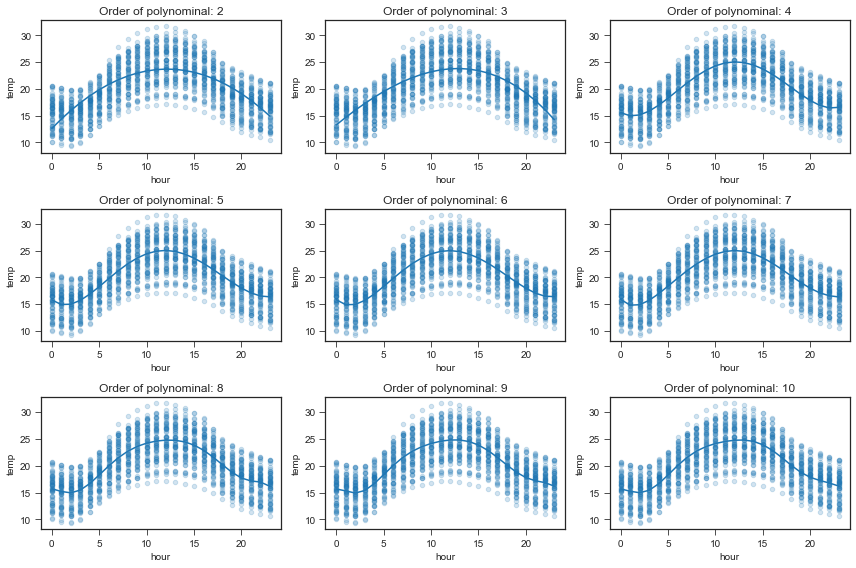

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(12,8))
ax = ax.flatten()

for i, axe in enumerate(ax):
    
    plTemp.plot.scatter("hour", "temp", alpha=0.2, ax=axe)
    axe.plot(preds[i])
    axe.set_title("Order of polynominal: {0}".format(i+2))

plt.tight_layout()
plt.show()


## Effect on MSE
Lets see how much better the performance of our model cen get with regularization.

In [14]:
# Benchmark, plain vanilla regression.

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import random

kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))
rmse = []
rmseT = []

for train, test in kf.split(plTemp.index.values):
    
    reg = linear_model.LinearRegression()
    reg.fit(plTemp.iloc[train][features], plTemp.iloc[train]["temp"])
    predsTrain = reg.predict(plTemp.iloc[train][features])
    preds = reg.predict(plTemp.iloc[test][features])
    rmse.append(mean_squared_error(plTemp.iloc[test].temp, preds))
    rmseT.append(mean_squared_error(plTemp.iloc[train].temp, predsTrain))
    
print(np.round(np.mean(rmseT), 2), np.round(np.mean(rmse), 2))


8.53 8.63


In [15]:
# Ridge.

kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))

for alpha in [0.1, 0.5, 2, 5, 10, 20, 100]:
    
    rmse = []
    rmseT = []
    
    for train, test in kf.split(plTemp.index.values):
        
        with warnings.catch_warnings(): # I am hiding warning here.
        
            warnings.filterwarnings("ignore")
            reg = linear_model.Ridge(alpha = alpha)
            reg.fit(plTemp.iloc[train][features], plTemp.iloc[train]["temp"])
            predsTrain = reg.predict(plTemp.iloc[train][features])
            preds = reg.predict(plTemp.iloc[test][features])
            rmse.append(mean_squared_error(plTemp.iloc[test].temp, preds))
            rmseT.append(mean_squared_error(plTemp.iloc[train].temp, predsTrain))
        
    print(np.round(alpha, 2), np.round(np.mean(rmseT), 2), np.round(np.mean(rmse), 2))


0.1 8.52 8.69
0.5 8.52 8.68
2 8.52 8.67
5 8.52 8.67
10 8.52 8.66
20 8.52 8.66
100 8.53 8.66


In [16]:
# LASSO.

kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))

for alpha in [0.01, 0.1, 0.25, 0.5, 1, 2, 5]:
    
    rmse = []
    rmseT = []
    
    for train, test in kf.split(plTemp.index.values):
        
        with warnings.catch_warnings(): # I am hiding warning here.
            
            warnings.filterwarnings("ignore")
            reg = linear_model.Lasso(alpha = alpha)
            reg.fit(plTemp.iloc[train][features], plTemp.iloc[train]["temp"])
            predsTrain = reg.predict(plTemp.iloc[train][features])
            preds = reg.predict(plTemp.iloc[test][features])
            rmse.append(mean_squared_error(plTemp.iloc[test].temp, preds))
            rmseT.append(mean_squared_error(plTemp.iloc[train].temp, predsTrain))
        
    print(np.round(alpha, 2), np.round(np.mean(rmseT), 2), np.round(np.mean(rmse), 2))


0.01 8.96 9.02
0.1 8.92 8.98
0.25 8.88 8.95
0.5 8.89 8.95
1 8.86 8.91
2 8.88 8.93
5 9.0 9.05


In [17]:
# Elastic Net.

kf = KFold(n_splits=5, shuffle=True, random_state=random.randint(0,10000))

for ratio in [0.1, 0.25, 0.5, 0.75, 0.9]:
    
    for alpha in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025]:
        
        rmse = []
        rmseT = []
        
        for train, test in kf.split(plTemp.index.values):
            
            with warnings.catch_warnings(): # I am hiding warning here.
                
                warnings.filterwarnings("ignore")
                reg = linear_model.ElasticNet(alpha = alpha, l1_ratio=ratio)
                reg.fit(plTemp.iloc[train][features], plTemp.iloc[train]["temp"])
                predsTrain = reg.predict(plTemp.iloc[train][features])
                preds = reg.predict(plTemp.iloc[test][features])
                rmse.append(mean_squared_error(plTemp.iloc[test].temp, preds))
                rmseT.append(mean_squared_error(plTemp.iloc[train].temp, predsTrain))
                
    print(np.round(alpha, 2), np.round(np.mean(rmseT), 2), np.round(np.mean(rmse), 2))


0.02 8.95 9.02
0.02 8.95 9.02
0.02 8.95 9.02
0.02 8.95 9.03
0.02 8.95 9.03


In this case we got the best results with Ridge. With Lasso the results got even worse. For Elastic Net there was little to no improvement.

Let's take a look at how different is the effect on additional features on Ridge, Lasso and Elastic Net.

In [18]:
# Elastic Net.

features = ["hour"]
preds = []
coefsEN = []
hours = pd.DataFrame(list(range(24)), columns=["hour"])

for power in range (2, 11):
    
    with warnings.catch_warnings(): # I am hiding warning here.

        warnings.filterwarnings("ignore")
        plTemp["hour"+str(power)] = plTemp.hour**power 
        hours["hour"+str(power)] = hours.hour**power 
        features.append("hour"+str(power))
        regr = linear_model.ElasticNet(alpha = 10)
        regr.fit(plTemp[features], plTemp["temp"])
        pred = regr.predict(hours[features])
        preds.append(pred)
        coefsEN.append(dict(zip(hours.columns, regr.coef_)))
        
coefsEN = pd.DataFrame(coefsEN)[hours.columns.tolist()]


In [19]:
# LASSO.

features = ["hour"]
preds = []
coefsL = []
hours = pd.DataFrame(list(range(24)), columns=["hour"])

for power in range (2, 11):
    
    with warnings.catch_warnings(): # I am hiding warning here.

        warnings.filterwarnings("ignore")
        plTemp["hour"+str(power)] = plTemp.hour**power 
        hours["hour"+str(power)] = hours.hour**power 
        features.append("hour"+str(power))
        regr = linear_model.Lasso(alpha = 10)
        regr.fit(plTemp[features], plTemp["temp"])
        pred = regr.predict(hours[features])
        preds.append(pred)
        coefsL.append(dict(zip(hours.columns, regr.coef_)))
        
coefsL = pd.DataFrame(coefsL)[hours.columns.tolist()]


In [20]:
# Ridge.

features = ["hour"]
preds = []
coefsR = []
hours = pd.DataFrame(list(range(24)), columns=["hour"])

for power in range (2, 11):
    
    with warnings.catch_warnings(): # I am hiding warning here.

        warnings.filterwarnings("ignore")
        plTemp["hour"+str(power)] = plTemp.hour**power 
        hours["hour"+str(power)] = hours.hour**power 
        features.append("hour"+str(power))
        regr = linear_model.Ridge(alpha = 10)
        regr.fit(plTemp[features], plTemp["temp"])
        pred = regr.predict(hours[features])
        preds.append(pred)
        coefsR.append(dict(zip(hours.columns, regr.coef_)))
    
coefsR = pd.DataFrame(coefsR)[hours.columns.tolist()]

print("No regularization:")
display(coefs)
print("Lasso:")
display(coefsL)
print("Ridge:")
display(coefsR)
print("Elastic Net:")
display(coefsEN)


No regularization:


hour     hour2     hour3     hour4     hour5         hour6  \
0  1.821602 -0.074865       NaN       NaN       NaN           NaN   
1  1.439996 -0.032491 -0.001228       NaN       NaN           NaN   
2 -1.023762  0.473688 -0.035929  0.000754       NaN           NaN   
3 -1.402442  0.598717 -0.050852  0.001491 -0.000013           NaN   
4 -1.539018  0.665478 -0.063002  0.002501 -0.000052  5.638650e-07   
5 -1.839844  0.871252 -0.115829  0.009001 -0.000464  1.358403e-05   
6 -0.194577 -0.635100  0.401224 -0.078412  0.007592 -3.989925e-04   
7  0.401007 -1.336664  0.710111 -0.146599  0.016081 -1.021798e-03   
8 -0.172437 -0.499989  0.253799 -0.020054 -0.004179  9.616380e-04   

          hour7         hour8         hour9        hour10  
0           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN  
5 -1.617412e-07           NaN           NaN           NaN  
6  1.086245e-05 -1.198282e-07           NaN           NaN  
7  3.756244e-05 -7.381959e-07  5.974567e-09           NaN  
8 -8.303801e-05  3.704506e-06 -8.480303e-08  7.893703e-10

Lasso:


hour     hour2     hour3     hour4     hour5         hour6         hour7  \
0   0.0 -0.000622       NaN       NaN       NaN           NaN           NaN   
1   0.0  0.095648 -0.004430       NaN       NaN           NaN           NaN   
2   0.0  0.093345 -0.004252 -0.000003       NaN           NaN           NaN   
3   0.0  0.135427 -0.005485 -0.000227  0.000009           NaN           NaN   
4   0.0  0.133987 -0.003323 -0.000313  0.000001  3.333103e-07           NaN   
5   0.0  0.117567 -0.001237 -0.000322 -0.000002  1.425773e-07  9.776880e-09   
6   0.0  0.104622 -0.000095 -0.000311 -0.000002  7.036957e-08  5.619295e-09   
7   0.0  0.098756  0.000219 -0.000296 -0.000003  5.021437e-08  4.142518e-09   
8   0.0  0.097332  0.000216 -0.000291 -0.000002  5.034186e-08  3.884580e-09   

          hour8         hour9        hour10  
0           NaN           NaN           NaN  
1           NaN           NaN           NaN  
2           NaN           NaN           NaN  
3           NaN           NaN           NaN  
4           NaN           NaN           NaN  
5           NaN           NaN           NaN  
6  2.543467e-10           NaN           NaN  
7  1.721336e-10  5.528901e-12           NaN  
8  1.513417e-10  4.307915e-12  7.197919e-14

Ridge:


hour     hour2     hour3     hour4     hour5         hour6  \
0  1.817804 -0.074711       NaN       NaN       NaN           NaN   
1  1.423130 -0.030828 -0.001273       NaN       NaN           NaN   
2 -0.979088  0.465801 -0.035438  0.000744       NaN           NaN   
3 -1.244141  0.555133 -0.046220  0.001281 -0.000009           NaN   
4 -1.184902  0.524541 -0.040493  0.000796  0.000010 -2.762669e-07   
5 -1.133913  0.484835 -0.029639 -0.000591  0.000100 -3.181461e-06   
6 -0.314968 -0.516747  0.360676 -0.071676  0.006984 -3.685031e-04   
7 -0.280000 -0.597495  0.406025 -0.083137  0.008542 -4.901224e-04   
8 -0.295408 -0.247069  0.104603  0.022174 -0.010941  1.618586e-03   

          hour7         hour8         hour9        hour10  
0           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN  
5  3.660490e-08           NaN           NaN           NaN  
6  1.006336e-05 -1.112940e-07           NaN           NaN  
7  1.552503e-05 -2.424300e-07  1.304075e-09           NaN  
8 -1.225466e-04  5.142456e-06 -1.138291e-07  1.038812e-09

Elastic Net:


hour     hour2     hour3     hour4         hour5         hour6  \
0  0.080883 -0.004085       NaN       NaN           NaN           NaN   
1  0.000000  0.101901 -0.004708       NaN           NaN           NaN   
2  0.000000  0.128732 -0.007785  0.000086           NaN           NaN   
3  0.000000  0.169400 -0.008810 -0.000146  9.066571e-06           NaN   
4  0.000000  0.165507 -0.006627 -0.000226  1.893008e-06  3.038792e-07   
5  0.000000  0.149733 -0.004737 -0.000231 -6.715364e-07  1.354207e-07   
6  0.000000  0.138513 -0.003796 -0.000220 -1.290190e-06  7.589568e-08   
7  0.000000  0.133544 -0.003515 -0.000211 -1.266454e-06  6.209256e-08   
8  0.000000  0.133075 -0.003574 -0.000208 -1.125106e-06  6.440462e-08   

          hour7         hour8         hour9        hour10  
0           NaN           NaN           NaN           NaN  
1           NaN           NaN           NaN           NaN  
2           NaN           NaN           NaN           NaN  
3           NaN           NaN           NaN           NaN  
4           NaN           NaN           NaN           NaN  
5  8.410521e-09           NaN           NaN           NaN  
6  4.924191e-09  2.059938e-10           NaN           NaN  
7  3.821711e-09  1.426186e-10  4.021136e-12           NaN  
8  3.731517e-09  1.313439e-10  3.276975e-12  2.872162e-14